## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy
from IPython.display import display

import matplotlib.pyplot as plt
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

print("Packages Imported!")

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Packages Imported!


## Settings

In [2]:
# MANIFEST_PATH = "E:/datasets/allen_vc/manifest_files/manifest.json"
MANIFEST_PATH = "D:/datasets/allen_vc/manifest.json"
PROJECT_PATH = "G:/Shared drives/visual_encoding"
# REPO_PATH = 'C:/Users/User/visual_encoding'
REPO_PATH = 'C:/Users/micha/projects/visual_encoding'

## Functions

In [4]:
def optotagging_spike_counts(session, bin_edges, trials, units):
    
    time_resolution = np.mean(np.diff(bin_edges))
    
    # Empty matrix for storing data
    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):
            
            # Mask for sectioning spike times based on bin
            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            # Create 0/1 spiketrain for correct unit and trial
            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )


def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))

    # Take mean across all trials, plot as image
    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(units)],
               aspect='auto', vmin=0, vmax=200)    

    # Plot stimulus start/end lines
    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(units)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')

## Load Dataset

In [5]:
# Create Allensdk cache object
cache = EcephysProjectCache.from_warehouse(manifest=MANIFEST_PATH)

In [6]:
# Isolate functional connectivity sections
sessions = cache.get_session_table()
functional_connectivity_sessions = sessions[sessions['session_type'] == 'functional_connectivity']

# Observe Cre distribution
functional_connectivity_sessions['full_genotype'].value_counts()

wt/wt                                              14
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       6
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       3
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     3
Name: full_genotype, dtype: int64

In [7]:
functional_connectivity_sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
766640955,2019-10-03T00:00:00Z,744912849,functional_connectivity,133.0,M,wt/wt,842,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, PF, TH, LP..."
767871931,2019-10-03T00:00:00Z,753795610,functional_connectivity,135.0,M,wt/wt,713,2231,6,"[MRN, APN, MB, DG, CA1, VISrl, nan, VISam, PO,..."
768515987,2019-10-03T00:00:00Z,754477358,functional_connectivity,136.0,M,wt/wt,802,2217,6,"[MB, APN, NOT, DG, CA1, VISam, nan, Eth, LP, P..."
771160300,2019-10-03T00:00:00Z,754488979,functional_connectivity,142.0,M,wt/wt,930,2230,6,"[SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A..."
771990200,2019-10-03T00:00:00Z,756578435,functional_connectivity,108.0,M,wt/wt,546,2229,6,"[APN, MB, DG, CA1, VISam, nan, PO, LP, VISpm, ..."


In [8]:
# Light delivery switched from LED (False) to Laser (True) halfway through
functional_connectivity_sessions.index.values >= 789848216

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

## Example Session

In [9]:
session = cache.get_session_data(786091066)
session.full_genotype

'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'

In [10]:
help(session)

Help on EcephysSession in module allensdk.brain_observatory.ecephys.ecephys_session object:

class EcephysSession(allensdk.core.lazy_property.lazy_property_mixin.LazyPropertyMixin)
 |  EcephysSession(api: allensdk.brain_observatory.ecephys.ecephys_session_api.ecephys_session_api.EcephysSessionApi, test: bool = False, **kwargs)
 |  
 |  Represents data from a single EcephysSession
 |  
 |  Attributes
 |  ----------
 |  units : pd.Dataframe
 |      A table whose rows are sorted units (putative neurons) and whose
 |      columns are characteristics of those units.
 |      Index is:
 |          unit_id : int
 |              Unique integer identifier for this unit.
 |      Columns are:
 |          firing_rate : float
 |              This unit's firing rate (spikes / s) calculated over the
 |              window of that unit's activity (the time from its first
 |              detected spike to its last).
 |          isi_violations : float
 |              Estamate of this unit's contamination

In [11]:
session.units.head()

,waveform_repolarization_slope,presence_ratio,L_ratio,waveform_velocity_above,amplitude_cutoff,waveform_duration,firing_rate,nn_miss_rate,cluster_id,local_index_unit,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950992037,0.827148,0.99,1.578580e-07,0.000000,0.000117,0.288442,13.173560,0.000000,0,0,...,10.0,SCig,8429.0,2697.0,6742.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992053,0.510683,0.99,9.216128e-08,NaN,0.000917,0.219765,10.146275,0.000000,2,2,...,10.0,SCig,8408.0,2656.0,6763.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992177,0.393553,0.99,1.054813e-03,0.686767,0.073858,1.098827,7.911522,0.000666,19,19,...,382.0,CA1,8026.0,1726.0,7340.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992173,0.933805,0.99,4.239420e-06,0.755444,0.000407,0.824121,4.363801,0.000049,18,18,...,382.0,CA1,8026.0,1726.0,7340.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992188,0.320981,0.99,7.454824e-04,1.442211,0.063526,1.194975,0.979358,0.000101,21,21,...,382.0,CA1,8020.0,1705.0,7355.0,probeA,See electrode locations,29999.965512,1249.998563,True


In [12]:
session.optogenetic_stimulation_epochs

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9215.34368,a single square pulse,1.0,9215.34868,pulse,0.005
1,9217.31384,a single square pulse,2.5,9217.32384,pulse,0.010
2,9219.35388,2.5 ms pulses at 10 Hz,4.0,9220.35388,fast_pulses,1.000
3,9221.34398,half-period of a cosine wave,2.5,9222.34398,raised_cosine,1.000
4,9223.23404,half-period of a cosine wave,2.5,9224.23404,raised_cosine,1.000
...,...,...,...,...,...,...
175,9554.72852,2.5 ms pulses at 10 Hz,1.0,9555.72852,fast_pulses,1.000
176,9556.56869,a single square pulse,2.5,9556.57369,pulse,0.005
177,9558.30871,a single square pulse,4.0,9558.31371,pulse,0.005


In [13]:
columns = ['stimulus_name', 'duration','level']

# All unique stimuli
session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])

,condition,level,stimulus_name,duration
id,,,,
9,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
0,a single square pulse,1.0,pulse,0.005
7,a single square pulse,2.5,pulse,0.005
16,a single square pulse,4.0,pulse,0.005
8,a single square pulse,1.0,pulse,0.010
1,a single square pulse,2.5,pulse,0.010
12,a single square pulse,4.0,pulse,0.010


In [13]:
"""
we've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. 
These pulses provide a long enough artifact-free window to observe light-evoked spikes, 
but do not last long enough to be contaminated by visually driven activity.
"""

# Select all stimulation trials for a duration
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]
# Select units of interest
units = session.units[session.units['ecephys_structure_acronym'] == 'VISp']

# Set bin surrounding stimulus params
time_resolution = 0.0005 # 0.5 ms bins
bin_edges = np.arange(-0.01, 0.025, time_resolution)

da = optotagging_spike_counts(session, bin_edges, trials, units)

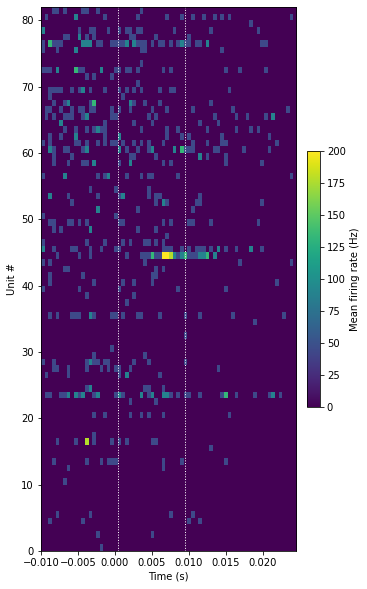

In [14]:
plot_optotagging_response(da)

In [15]:
# Sum spikes across time slice, take mean over trials --> mean firing rate
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))
baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))
evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

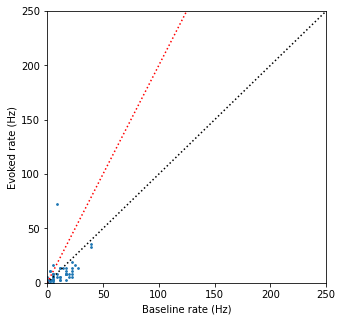

In [16]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 250
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

In [17]:
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors
cre_pos_units

array([951001485, 951001777, 951002222, 951002348, 951002333, 951002295,
       951002529, 951003999, 951002943], dtype=int64)

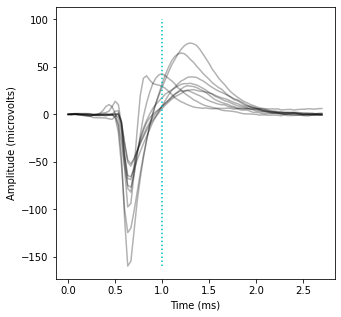

In [18]:
plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    # Locate peak channel for unit, extract waveform data, plot
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
_ =plt.plot([1.0, 1.0],[-160, 100],':c')

## Compute Cell Type Features

In [20]:
# Goals:

# - Find number and proportion of responsive units to opto stimuli (and by how much)
# - Based on waveform characteristics of Excitatory v Inhibitory, classify each unit
# - Final unit dataframe for each session with relevant features

In [21]:
# Get relevant units, keep waveform stats, compute optogenetic response (all 10 ms pulses for now)

In [22]:
# Define function to compute baseline and evoked rate for all units in a session, across all trials, for a particular stim

def calc_optotagging_response(session, stimulus_params, region, raster_plot=False, scatter_plot=False):
    
    duration = stimulus_params.get('duration') # Must be provided
    level = stimulus_params.get('level', None)
    name = stimulus_params.get('stimulus_name', None)
    
    # Select trials
    trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > duration - 0.001) & \
                                                    (session.optogenetic_stimulation_epochs.duration < duration + 0.001)]
    if level is not None:
        level_val = sorted(trials['level'].unique())[level-1]
        trials = trials[(trials['level'] == level_val)]
    if name is not None:
        trials = trials[(trials['stimulus_name'] == name)]
        
    if len(trials) == 0:
        return _, _, _, False
    
    # Select units of interest
    units = session.units[session.units['ecephys_structure_acronym'] == region]

    # Set bin surrounding stimulus params
    time_resolution = 0.0005 # 0.5 ms bins
    bin_edges = np.arange(-duration, duration*2.5, time_resolution) # observe 1*duration before stim and 2.5*duration after

    da = optotagging_spike_counts(session, bin_edges, trials, units)
    
    if raster_plot:
        plot_optotagging_response(da)
    
    # Section data based on time relative to stimulus onset and compute firing rates
    baseline = da.sel(time_relative_to_stimulus_onset=slice(-duration,-0.002))
    baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset') / (duration-0.002)
    
    evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001, duration - 0.001))
    evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset') / (duration-0.002)
    
    if scatter_plot:
        
        plt.figure(figsize=(5,5))

        plt.scatter(baseline_rate.mean(dim='trial_id'), evoked_rate.mean(dim='trial_id'), s=3)

        axis_limit = 250
        plt.plot([0,axis_limit],[0,axis_limit], ':k')
        plt.plot([0,axis_limit],[0,axis_limit*2], ':r') # 2*baseline response
        plt.xlim([0,axis_limit])
        plt.ylim([0,axis_limit])

        plt.xlabel('Baseline rate (Hz)')
        _ = plt.ylabel('Evoked rate (Hz)')
        
    return da.unit_id, baseline_rate, evoked_rate, True

Positive Units: [951001485 951001777 951002222 951002348 951002333 951002295 951002529
 951003999 951002943]


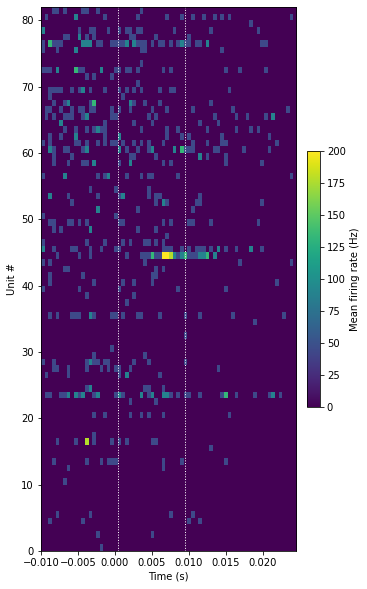

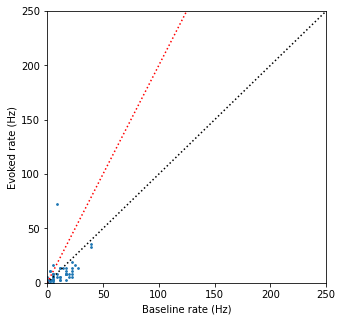

In [23]:
# Example
stimulus_params = {'duration': 0.01}
units, baseline_rate, evoked_rate, _ = calc_optotagging_response(session, stimulus_params, 'VISp', raster_plot=True, scatter_plot=True)
print(f"Positive Units: {units[(evoked_rate.mean(dim='trial_id') / (baseline_rate.mean(dim='trial_id') + 1)) > 2].values}") # +1 zerodivisionerror can be better

Let's calculate these metrics for multiple stimuli across all sessions.

In [24]:
# define utility function for computing baseline and evoked rates into a DataFrame

def create_unit_opto_df(region, stimulus_params, fname_out=None):
    
    unit_dfs = []
    
    for session_id in functional_connectivity_sessions.index:
        print(f'Computing Session: \t {session_id}')

        session = cache.get_session_data(session_id)

        _, baseline_rate, evoked_rate, has_trials = calc_optotagging_response(session, stimulus_params, region, raster_plot=False, scatter_plot=False)
        
        if not has_trials:
            print(f'\t\tNo trials found for this stimulus!')
            continue

        units = session.units[session.units['ecephys_structure_acronym'] == region][['ecephys_structure_acronym']].reset_index()

        units['genotype'] = session.full_genotype
        units['trial_id'] = [range(baseline_rate.shape[0])]*units.shape[0]
        units['opto_baseline_rate'], units['opto_evoked_rate'] = [list(x) for x in np.swapaxes(baseline_rate.values,0,1)], [list(x) for x in np.swapaxes(evoked_rate.values,0,1)]

        unit_dfs.append(units)
        
    all_units_df = pd.concat(unit_dfs).explode(['opto_baseline_rate', 'opto_evoked_rate', 'trial_id']).reset_index(drop=True)
        
    if fname_out is not None:
        all_units_df.to_csv(fname_out, index=False)
        
    return create_unit_opto_df


In [25]:
columns = ['stimulus_name', 'duration','level']

for session_id in functional_connectivity_sessions.index:

    session = cache.get_session_data(session_id)

    # All unique stimuli
    unique_stim = session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])
    
    # display(unique_stim)
    
    print(f'Session: {session_id}, Names: {unique_stim[columns[0]].unique()}, Durations: {unique_stim[columns[1]].unique()}, Levels: {unique_stim[columns[2]].unique()}')

Session: 766640955, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 767871931, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 768515987, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 771160300, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 771990200, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 774875821, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 778240327, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 778998620, Names: ['fast_pulses' 'pulse' 'raised_cosine'], Durations: [1.    0.005 0.01 ], Levels: [1.  2.5 4. ]
Session: 779839471, Name

We see that the "level" description for later sessions is not identical.

In [27]:
# create dataframe with all unique stimuli across subjects

stimuli_df = session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])
stimuli_df['level'] = [1,2,3,1,2,3,1,2,3,1,2,3] # change level to rank order
stimuli_df

,condition,level,stimulus_name,duration
id,,,,
25,2.5 ms pulses at 10 Hz,1,fast_pulses,1.000
1,2.5 ms pulses at 10 Hz,2,fast_pulses,1.000
8,2.5 ms pulses at 10 Hz,3,fast_pulses,1.000
16,a single square pulse,1,pulse,0.005
3,a single square pulse,2,pulse,0.005
7,a single square pulse,3,pulse,0.005
14,a single square pulse,1,pulse,0.010
12,a single square pulse,2,pulse,0.010
4,a single square pulse,3,pulse,0.010


In [ ]:
region = 'VISp'
out_dir = 'G:/Shared drives/visual_encoding/data/optotagging_data'

for stimuli in stimuli_df.iterrows():
    
    
    stimulus_params = stimuli[1].to_dict()
    print(f'Stimulus: {stimulus_params}')
    
    stim_name, duration, level = stimulus_params['stimulus_name'], stimulus_params['duration'], stimulus_params['level']
    if not os.path.exists(f'{out_dir}/{stim_name}'):
        os.mkdir(f'{out_dir}/{stim_name}')
    
    create_unit_opto_df(region, stimulus_params, f'{out_dir}/{stim_name}/{duration}s_{level}.csv')

Stimulus: {'condition': '2.5 ms pulses at 10 Hz', 'level': 1, 'stimulus_name': 'fast_pulses', 'duration': 1.0}
Computing Session: 	 766640955
Computing Session: 	 767871931
Computing Session: 	 768515987
Computing Session: 	 771160300
Computing Session: 	 771990200
Computing Session: 	 774875821
Computing Session: 	 778240327
Computing Session: 	 778998620
Computing Session: 	 779839471
Computing Session: 	 781842082
Computing Session: 	 786091066
Computing Session: 	 787025148
Computing Session: 	 789848216
Computing Session: 	 793224716
Computing Session: 	 794812542
Computing Session: 	 816200189
Computing Session: 	 819186360
Computing Session: 	 819701982
Computing Session: 	 821695405
Computing Session: 	 829720705
Computing Session: 	 831882777
Computing Session: 	 835479236
Computing Session: 	 839068429
Computing Session: 	 839557629
Computing Session: 	 840012044
Computing Session: 	 847657808
Stimulus: {'condition': '2.5 ms pulses at 10 Hz', 'level': 2, 'stimulus_name': 'fas

Code below does not work without averaging across trials

In [55]:
all_units_df['genotype'].value_counts()

wt/wt                                              966
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      422
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    151
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      140
Name: genotype, dtype: int64

In [56]:
all_units_df['evoked_baseline_ratio'] = all_units_df['opto_evoked_rate']/all_units_df['opto_baseline_rate']
np.isinf(all_units_df['evoked_baseline_ratio']).sum()

165

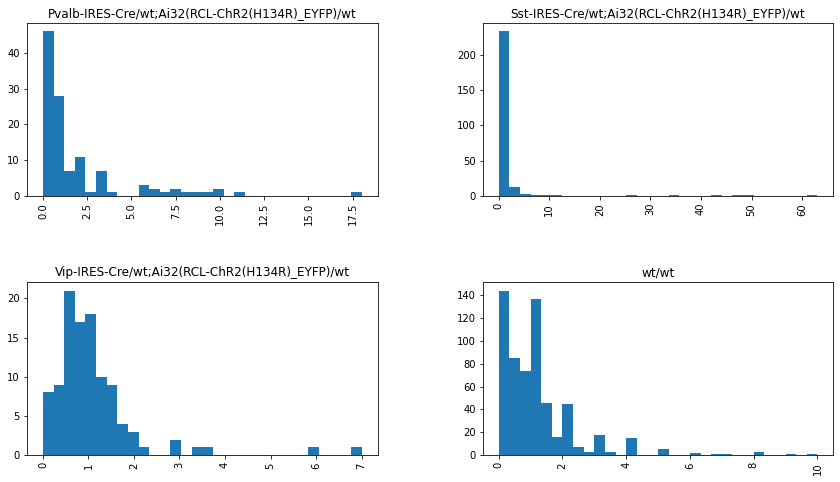

In [57]:
# drop inf ratios for now
all_units_df = all_units_df[~np.isinf(all_units_df['evoked_baseline_ratio'])]
all_units_df.dropna().hist('evoked_baseline_ratio', by='genotype', figsize=(14, 8), bins=30);

## compute response reliability

In [19]:
# load example results
fname = fr"G:\Shared drives\visual_encoding\data\optotagging_data\pulse\0.01000000000021828s_3.csv"
df = pd.read_csv(fname)
df

,unit_id,ecephys_structure_acronym,genotype,trial_id,opto_baseline_rate,opto_evoked_rate
0,950929283,VISp,wt/wt,0,0.0,0.0
1,950929283,VISp,wt/wt,1,0.0,0.0
2,950929283,VISp,wt/wt,2,0.0,0.0
3,950929283,VISp,wt/wt,3,0.0,0.0
4,950929283,VISp,wt/wt,4,0.0,0.0
...,...,...,...,...,...,...
35116,951187369,VISp,wt/wt,20,125.0,0.0
35117,951187369,VISp,wt/wt,21,0.0,0.0
35118,951187369,VISp,wt/wt,22,0.0,125.0
35119,951187369,VISp,wt/wt,23,0.0,0.0


In [20]:
# compute response reliability for example unit
unit_ids = df['unit_id'].unique()
unit_id = unit_ids[-1]
unit_df = df[df['unit_id'] == unit_id]
unit_df['responded'] = unit_df['opto_evoked_rate'] > unit_df['opto_baseline_rate']
response_relability = unit_df['responded'].sum() / unit_df.shape[0]
print(response_relability)
unit_df

0.16


C:\Users\User\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,unit_id,ecephys_structure_acronym,genotype,trial_id,opto_baseline_rate,opto_evoked_rate,responded
35096,951187369,VISp,wt/wt,0,0.0,125.0,True
35097,951187369,VISp,wt/wt,1,0.0,0.0,False
35098,951187369,VISp,wt/wt,2,0.0,0.0,False
35099,951187369,VISp,wt/wt,3,0.0,0.0,False
35100,951187369,VISp,wt/wt,4,0.0,0.0,False
35101,951187369,VISp,wt/wt,5,0.0,0.0,False
35102,951187369,VISp,wt/wt,6,0.0,0.0,False
35103,951187369,VISp,wt/wt,7,0.0,0.0,False
35104,951187369,VISp,wt/wt,8,125.0,125.0,False
35105,951187369,VISp,wt/wt,9,0.0,125.0,True


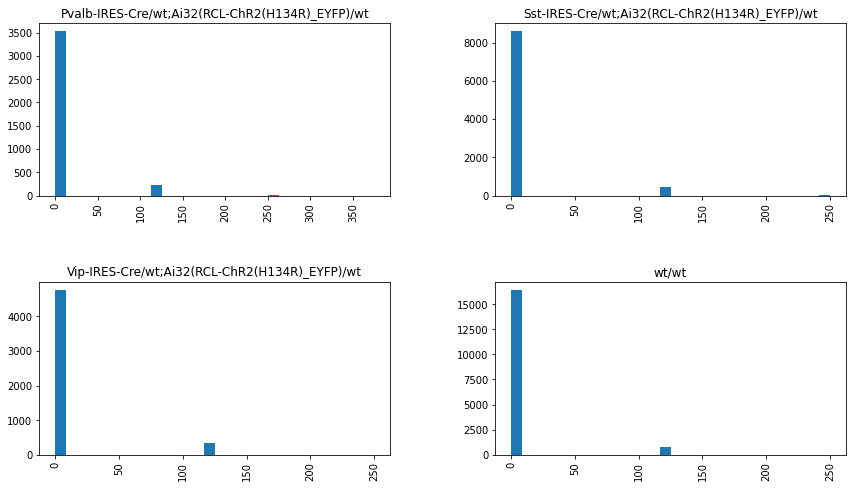

In [21]:
df.dropna().hist('opto_baseline_rate', by='genotype', figsize=(14, 8), bins=30);

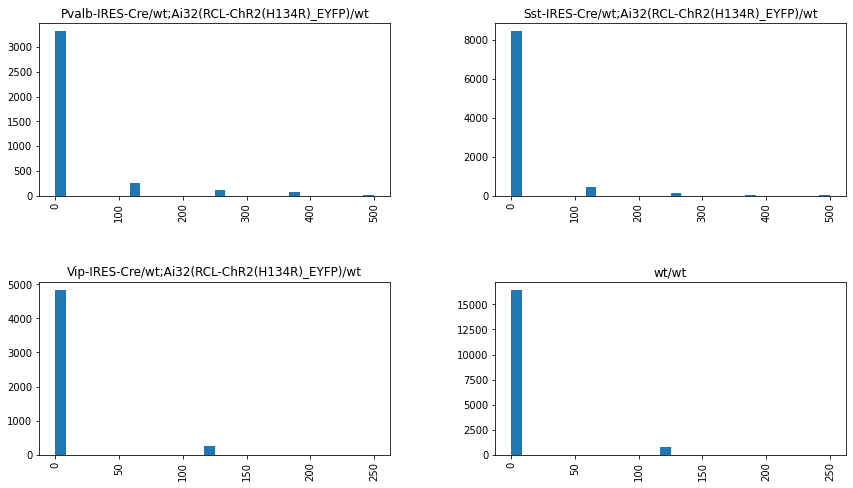

In [22]:
df.dropna().hist('opto_evoked_rate', by='genotype', figsize=(14, 8), bins=30);

In [4]:
def compute_response_reliability(df, unit_id):
        """
        Compute response reliability for a unit across all trials. Response reliability is 
        defined as the proportion of trials in which the unit responded to the stimulus.
        """
        
        unit_df = df[df['unit_id'] == unit_id]
        unit_df['responded'] = unit_df['opto_evoked_rate'] > unit_df['opto_baseline_rate']
        response_relability = unit_df['responded'].sum() / unit_df.shape[0]
        
        return response_relability

In [17]:
# compute response reliability for all units

# init
rr = df.groupby(['unit_id', 'ecephys_structure_acronym', 'genotype']).mean().drop(columns=['trial_id', 'opto_baseline_rate', 'opto_evoked_rate']).reset_index()
rr.assign(response_relability=np.nan)

# compute rr
for unit in rr['unit_id'].unique():
    rr.loc[rr['unit_id']==unit, 'response_relability'] = compute_response_reliability(df, unit)

rr

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,unit_id,ecephys_structure_acronym,genotype,response_relability
0,950922446,VISp,wt/wt,0.200000
1,950922495,VISp,wt/wt,0.155556
2,950922511,VISp,wt/wt,0.211111
3,950922546,VISp,wt/wt,0.072222
4,950922579,VISp,wt/wt,0.094444
...,...,...,...,...
1674,951187345,VISp,wt/wt,0.293333
1675,951187357,VISp,wt/wt,0.110000
1676,951187369,VISp,wt/wt,0.383333
1677,951187421,VISp,wt/wt,0.253333


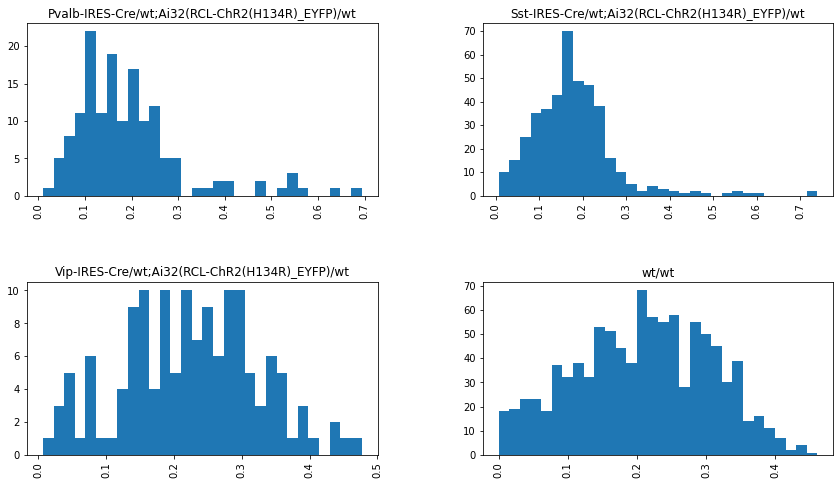

In [18]:
# plot results
rr.dropna().hist('response_relability', by='genotype', figsize=(14, 8), bins=30);

Compute response reliability across all stimuli and between conditions

In [26]:
# visualization and analysis here

# load dfs, concatenate, compute response ratio 

# loop through all stimuli
# loop through each genotype
# for each stimuli show swarm plot with each level (response reliability on y)

# 4 stimuli x 4 genoytpes each with a swarm plot including 3 levels

In [42]:
fname = "G:/Shared drives/visual_encoding/data/optotagging_data/concat"
dfs = []

for stimuli in os.listdir(fname):
    if stimuli == 'concat':
        break
    
    for dur_level in os.listdir(f'{fname}/{stimuli}'):
        df = pd.read_csv(f'{fname}/{stimuli}/{dur_level}')
        df['opto_stimulus'] = f'{stimuli}_{dur_level[:-4]}'
        
        dfs.append(df)
        
pd.concat(dfs).to_csv(f'{fname}/all_stimuli.csv', index=False)

In [5]:
# load stimulus info
fname = "G:/Shared drives/visual_encoding/data/optotagging_data/concat"
df = pd.read_csv(f'{fname}/all_stimuli.csv')
df.head()

,unit_id,ecephys_structure_acronym,genotype,trial_id,opto_baseline_rate,opto_evoked_rate,opto_stimulus
0,950929283,VISp,wt/wt,0,7.014028,6.012024,fast_pulses_1.0s_1
1,950929283,VISp,wt/wt,1,4.008016,2.004008,fast_pulses_1.0s_1
2,950929283,VISp,wt/wt,2,6.012024,4.008016,fast_pulses_1.0s_1
3,950929283,VISp,wt/wt,3,6.012024,2.004008,fast_pulses_1.0s_1
4,950929283,VISp,wt/wt,4,2.004008,5.010020,fast_pulses_1.0s_1


In [6]:
# compute response reliability
rrs = []

# for each stimulus
for stimulus in df['opto_stimulus'].unique():
    df_stim = df[df['opto_stimulus'] == stimulus]
    df_rr = df_stim.groupby(['unit_id', 'ecephys_structure_acronym', 'genotype']).mean().drop(columns=['trial_id', 'opto_baseline_rate', 'opto_evoked_rate']).reset_index()
    df_rr['opto_stimulus'] = stimulus
    df_rr.assign(response_relability=np.nan)
    
    for unit in df_rr['unit_id'].unique():
        df_rr.loc[df_rr['unit_id']==unit, 'response_reliability'] = compute_response_reliability(df_stim, unit)
        
    rrs.append(df_rr)
    
df_rr = pd.concat(rrs)

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
# load / save results
df_rr.to_csv('G:/Shared drives/visual_encoding/data/optotagging_data/concat/all_stimuli_rr.csv', index=False)
df_rr = pd.read_csv('G:/Shared drives/visual_encoding/data/optotagging_data/concat/all_stimuli_rr.csv')

df_rr.head()


,unit_id,ecephys_structure_acronym,genotype,opto_stimulus,response_reliability
0,950922446,VISp,wt/wt,fast_pulses_1.0s_1,0.533333
1,950922495,VISp,wt/wt,fast_pulses_1.0s_1,0.133333
2,950922511,VISp,wt/wt,fast_pulses_1.0s_1,0.200000
3,950922546,VISp,wt/wt,fast_pulses_1.0s_1,0.133333
4,950922579,VISp,wt/wt,fast_pulses_1.0s_1,0.200000


In [9]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# create level column
df_rr['stim_level'] = df_rr['opto_stimulus'].str[-1]
df_rr['stim_name'] = df_rr['opto_stimulus'].str[:-2]

fig, axs = plt.subplots(4, 4, figsize=(20,20), sharey=True, sharex=True)

# loop through all stimuli
for i, stimulus in enumerate(df_rr['stim_name'].unique()):
    # and through all genotypes
    for j, genotype in enumerate(df_rr['genotype'].unique()):
        
        df = df_rr[(df_rr['stim_name'] == stimulus) & (df_rr['genotype'] == genotype)]
        
        # plot swarmplot of response reliability for each level
        sns.violinplot(data=df, x='stim_level', y='response_reliability', ax=axs[i,j])
        sns.swarmplot(data=df, x='stim_level', y='response_reliability', ax=axs[i,j])
        
        if i==3:
            axs[i,j].set_xlabel(genotype)
        else:
            axs[i,j].set_xlabel('')
        if j==0:
            axs[i,j].set_ylabel(stimulus)
        else:
            axs[i,j].set_ylabel('')
        
fig.text(0.5, 0.04, 'genotype', ha='center')
fig.text(0.04, 0.5, 'stimulus', va='center', rotation='vertical');

In [20]:
"""
we've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. 
These pulses provide a long enough artifact-free window to observe light-evoked spikes, 
but do not last long enough to be contaminated by visually driven activity.
"""

"\nwe've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. \nThese pulses provide a long enough artifact-free window to observe light-evoked spikes, \nbut do not last long enough to be contaminated by visually driven activity.\n"

NOTE: data appear to be distributed incrementally because response reliability is calculated as (# units responded/# trials) and # trials is either 15-25.

Hypothesis: longer stimuli are contaminated by visually driven activity, explaining larger "response" rates in those stimuli. wt/wt includes significantly more subjects/units than Vip, resulting in a wider overall distribution of random responses and contaminated visually driven activity compared to Vip.

In [27]:
# select only pulse stimuli
df_pulse = df_rr[df_rr['opto_stimulus'].str[:5] == 'pulse']

# only wt
df_wt = df_pulse[df_pulse['genotype'] == 'wt/wt']
df_wt

,unit_id,ecephys_structure_acronym,genotype,opto_stimulus,response_reliability,stim_level,stim_name
0,950922446,VISp,wt/wt,pulse_0.0049999999991996455s_1,0.00,1,pulse_0.0049999999991996455s
1,950922495,VISp,wt/wt,pulse_0.0049999999991996455s_1,0.00,1,pulse_0.0049999999991996455s
2,950922511,VISp,wt/wt,pulse_0.0049999999991996455s_1,0.00,1,pulse_0.0049999999991996455s
3,950922546,VISp,wt/wt,pulse_0.0049999999991996455s_1,0.00,1,pulse_0.0049999999991996455s
4,950922579,VISp,wt/wt,pulse_0.0049999999991996455s_1,0.00,1,pulse_0.0049999999991996455s
...,...,...,...,...,...,...,...
1674,951187345,VISp,wt/wt,pulse_0.01000000000021828s_3,0.12,3,pulse_0.01000000000021828s
1675,951187357,VISp,wt/wt,pulse_0.01000000000021828s_3,0.00,3,pulse_0.01000000000021828s
1676,951187369,VISp,wt/wt,pulse_0.01000000000021828s_3,0.16,3,pulse_0.01000000000021828s
1677,951187421,VISp,wt/wt,pulse_0.01000000000021828s_3,0.00,3,pulse_0.01000000000021828s


In [23]:
# visualize wildtype distributions for pulse 5ms and 10ms, fit curve to gaussian, compute threshold, plot

In [131]:
# function for curve fitting, plotting dist, and calc 95% CI


#Define the Gaussian function 
def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def exponential(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) / sigma)


def gaussian_fit_plot(data, bins=100, z_score=None, ax=None, function='gauss'):
    
    # compute distribution data points based on bins
    y, x = np.histogram(data, bins=bins)
    x = (x[1:] + x[:-1]) / 2 # bin centers
    print(np.min(x), np.max(x))
    
    # fit gaussian function to data points
    if function=='gauss':
        params, cov = scipy.optimize.curve_fit(gauss, x, y, p0=[0, 100, 0, 0.05], maxfev=5000)
    elif (function=='exp') | (function=='exponential'):
        params, cov = scipy.optimize.curve_fit(exponential, x, y, p0=[0, 500, 0, 0.05], maxfev=5000)
    else:
        raise ValueError('function must be either gauss or exp')
    
    # plot histogram with fit curve
    ax.hist(data, bins=bins)
    
    # t = np.linspace(-0.05, 0.1, 1000)
    t = x.copy()
    if function=='gauss':
        ax.plot(t, gauss(t, *params))
    elif (function=='exp') | (function=='exponential'):
        ax.plot(t, exponential(t, *params))
    
    # ax.set_xlim([-0.05, 0.4])
    
    # compute z_score value and plot
    if z_score is not None:
        cutoff = params[-2] + z_score*params[-1]
        ax.axvline(cutoff, color='red', linestyle='--')
        
        print(f'{params} --- {cutoff}')
        
        return cutoff
    
    return params
        

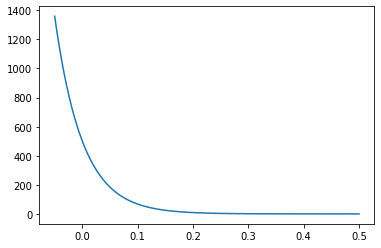

In [99]:
# test exponential function
x = np.linspace(-0.05, 0.5, 1000)
y = exponential(x, 0, 500, 0, 0.05)
plt.plot(x, y)


[2.06060604e+00 7.66598125e+02 1.35704010e-03 3.25229499e-04] --- 0.0018936687681020826
[2.26262618e+00 7.57440029e+02 2.22869978e-03 7.87635286e-04] --- 0.003528297998082435
[2.24242407e+00 7.45434678e+02 1.62476097e-03 4.21379094e-04] --- 0.0023200364726102016
[3.77777730e+00 5.88464120e+02 1.98128475e-03 6.52051983e-04] --- 0.003057170525031486
[3.76767699e+00 6.83351583e+02 2.79216940e-03 7.20346148e-04] --- 0.003980740545410233
[3.72727270e+00 8.28955694e+02 2.50994086e-03 1.00665590e-03] --- 0.004170923087583992


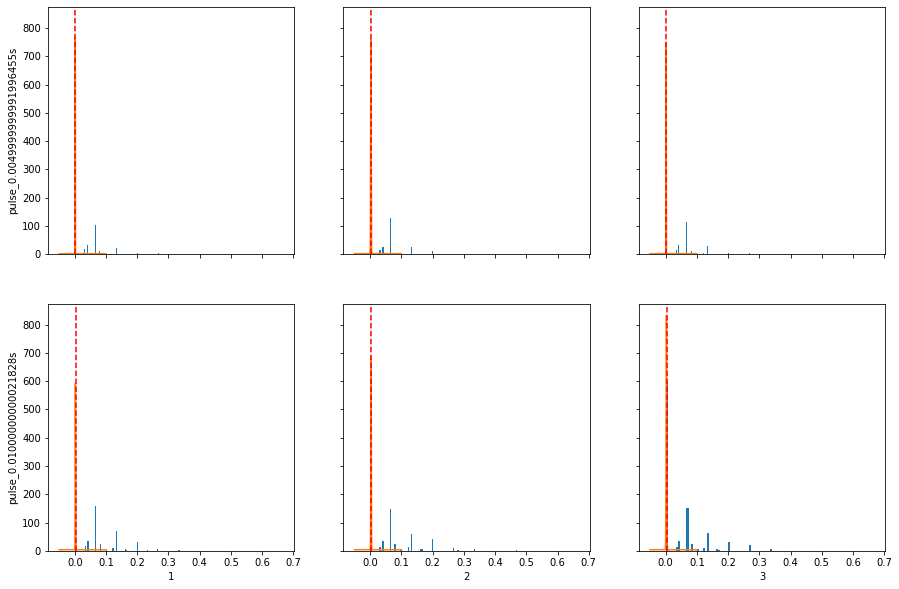

In [108]:
# select only pulse stimuli
df_pulse = df_rr[df_rr['opto_stimulus'].str[:5] == 'pulse']

# only wt
df_wt = df_pulse[df_pulse['genotype'] == 'wt/wt']

# create dict for storing thresholds
thresholds = {}

fig, axes = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True)

for i, stim in enumerate(df_wt['stim_name'].unique()):
    
    df_stim = df_wt[df_wt['stim_name'] == stim]
    
    for j, level in enumerate(df_stim['stim_level'].unique()):
        df_level = df_stim[df_stim['stim_level'] == level]
        
        thresholds[f'{stim}_{level}'] = gaussian_fit_plot(np.array(df_level['response_reliability']), z_score=1.65, ax=axes[i,j])
        
        if i == 1:
            axes[i, j].set_xlabel(level)
        if j==0:
            axes[i, j].set_ylabel(stim)
        
        #axes[i, j].set_title(f'{stim} - {level}')

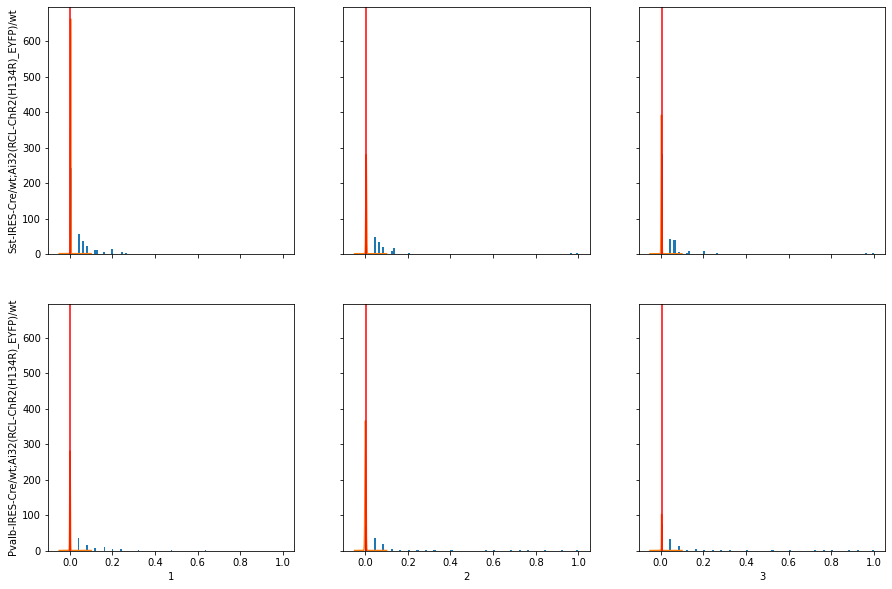

In [35]:
# select only pulse 10ms
stim = 'pulse_0.01000000000021828s'
df_stim = df_rr[(df_rr['stim_name'] == stim) & (df_rr['genotype'] != 'wt/wt') 
                & (df_rr['genotype'] != 'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt')]


fig, axes = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True)

  
for i, gen in enumerate(df_stim['genotype'].unique()):
    
    df_gen = df_stim[df_stim['genotype'] == gen]
    
    for j, level in enumerate(df_gen['stim_level'].unique()):

        df_level = df_gen[df_gen['stim_level'] == level]

        gaussian_fit_plot(np.array(df_level['response_reliability']), ax=axes[i,j])

        # axes[i, j].set_title(f'{gen} - {level}')
        axes[i, j].axvline(thresholds[f'{stim}_{level}'], color='red')
        
        if i == 1:
            axes[i, j].set_xlabel(level)
        if j==0:
            axes[i, j].set_ylabel(gen)

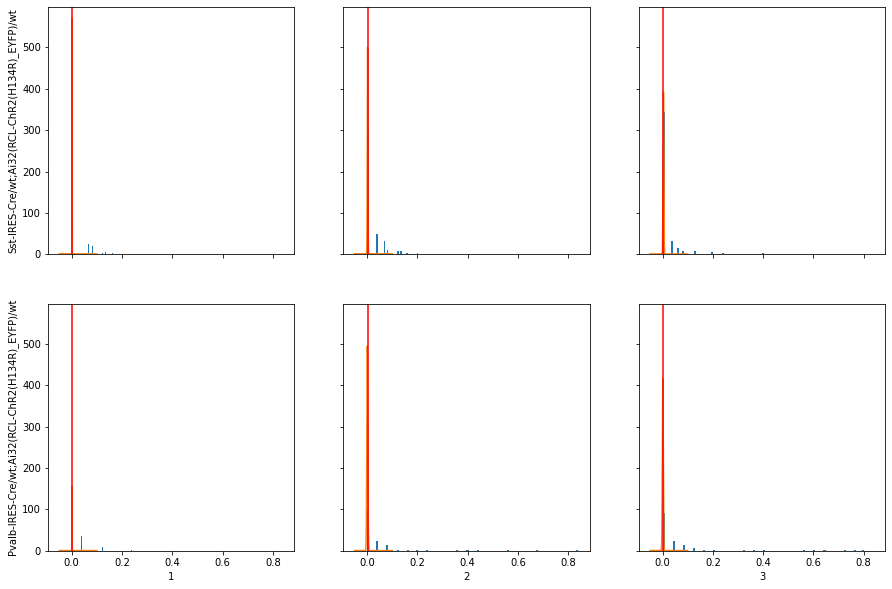

In [36]:
# select only pulse 5ms
stim = 'pulse_0.0049999999991996455s'
df_stim = df_rr[(df_rr['stim_name'] == stim) & (df_rr['genotype'] != 'wt/wt') 
                & (df_rr['genotype'] != 'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt')]


fig, axes = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True)

  
for i, gen in enumerate(df_stim['genotype'].unique()):
    
    df_gen = df_stim[df_stim['genotype'] == gen]
    
    for j, level in enumerate(df_gen['stim_level'].unique()):

        df_level = df_gen[df_gen['stim_level'] == level]

        gaussian_fit_plot(np.array(df_level['response_reliability']), ax=axes[i,j])

        # axes[i, j].set_title(f'{gen} - {level}')
        axes[i, j].axvline(thresholds[f'{stim}_{level}'], color='red')
        
        if i == 1:
            axes[i, j].set_xlabel(level)
        if j==0:
            axes[i, j].set_ylabel(gen)

0.025 0.925
0.025 0.925


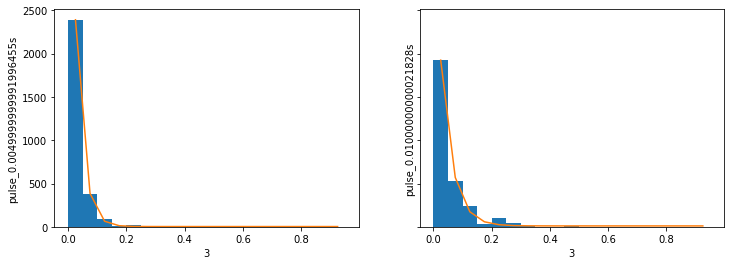

In [173]:
# Update
"""
* group all power levels together
* use wider histogram bins
* use exponential function for fitting
"""

# define bin edges (0-1s, 50 ms bins)
bin_edges = np.arange(0, 1, 0.05)

# select only pulse stimuli
df_pulse = df_rr[df_rr['opto_stimulus'].str[:5] == 'pulse']

# only wt
df_wt = df_pulse[df_pulse['genotype'] == 'wt/wt']

# create dict for storing thresholds
params = {}

fig, axes = plt.subplots(1,2, figsize=(12, 4), sharex=True, sharey=True)

for i, stim in enumerate(df_wt['stim_name'].unique()):
    
    df_stim = df_wt[df_wt['stim_name'] == stim]
    
    params[f'{stim}'] = gaussian_fit_plot(np.array(df_stim['response_reliability']), ax=axes[i],
                                                bins=bin_edges, function='exp')
    
    axes[i].set_xlabel(level)
    axes[i].set_ylabel(stim)
    
    #axes[i, j].set_title(f'{stim} - {level}')

In [179]:
# compute 99% confidence interval from exponential params
from scipy.stats import expon
for stim in list(params.keys()):
    confidence_interval = expon.interval(0.99, loc=params[stim][2], scale=params[stim][3])

    print(f"\n\n================ stim:\t{stim} ================")
    print(f"loc = {params[stim][2]}, scale = {params[stim][3]}")
    print(f"confidence interval = {confidence_interval}")



================ stim:	pulse_0.0049999999991996455s ================
loc = 0.05545789105324813, scale = 0.02729357243913183
confidence interval = (0.05559470122661322, 0.20006789990263713)


================ stim:	pulse_0.01000000000021828s ================
loc = 0.05671027992192419, scale = 0.04062661693869404
confidence interval = (0.05691392253847851, 0.27196298999230145)


### apply thresholds

In [89]:
# load results
df_rr = pd.read_csv('G:/Shared drives/visual_encoding/data/optotagging_data/concat/all_stimuli_rr.csv')
print(f"N units:\t{len(df_rr['unit_id'].unique())}")
print(f"N stimuli:\t{len(df_rr['opto_stimulus'].unique())}")
df_rr


N units:	1679
N stimuli:	12


,unit_id,ecephys_structure_acronym,genotype,opto_stimulus,response_reliability
0,950922446,VISp,wt/wt,fast_pulses_1.0s_1,0.533333
1,950922495,VISp,wt/wt,fast_pulses_1.0s_1,0.133333
2,950922511,VISp,wt/wt,fast_pulses_1.0s_1,0.200000
3,950922546,VISp,wt/wt,fast_pulses_1.0s_1,0.133333
4,950922579,VISp,wt/wt,fast_pulses_1.0s_1,0.200000
...,...,...,...,...,...
20143,951187345,VISp,wt/wt,raised_cosine_1.0s_3,0.560000
20144,951187357,VISp,wt/wt,raised_cosine_1.0s_3,0.360000
20145,951187369,VISp,wt/wt,raised_cosine_1.0s_3,0.920000
20146,951187421,VISp,wt/wt,raised_cosine_1.0s_3,0.560000


In [90]:
# init
thresholds = [0.20, 0.272]
stim_ids = ['pulse_0.0049999999991996455s', 'pulse_0.01000000000021828s']

# rename columns - drop power level (last 2 characters)
df_rr['opto_stimulus'] = df_rr['opto_stimulus'].str[:-2]

# apply threshold
df_rr['tagged'] = np.nan
for ii in range(len(stim_ids)):
    df_rr.loc[df_rr['opto_stimulus']==stim_ids[ii], 'tagged'] = df_rr.loc[df_rr['opto_stimulus']==stim_ids[ii], 'response_reliability'] > thresholds[ii]

# drop other stimuli
df_tag = df_rr.dropna(subset=['tagged'])
df_tag

,unit_id,ecephys_structure_acronym,genotype,opto_stimulus,response_reliability,tagged
5037,950922446,VISp,wt/wt,pulse_0.0049999999991996455s,0.00,False
5038,950922495,VISp,wt/wt,pulse_0.0049999999991996455s,0.00,False
5039,950922511,VISp,wt/wt,pulse_0.0049999999991996455s,0.00,False
5040,950922546,VISp,wt/wt,pulse_0.0049999999991996455s,0.00,False
5041,950922579,VISp,wt/wt,pulse_0.0049999999991996455s,0.00,False
...,...,...,...,...,...,...
15106,951187345,VISp,wt/wt,pulse_0.01000000000021828s,0.12,False
15107,951187357,VISp,wt/wt,pulse_0.01000000000021828s,0.00,False
15108,951187369,VISp,wt/wt,pulse_0.01000000000021828s,0.16,False
15109,951187421,VISp,wt/wt,pulse_0.01000000000021828s,0.00,False


In [122]:
# check number of tagged units
df_t = df_tag.copy()
df_t['n_activated'] = df_t['tagged'].astype(int)
df_t = df_t.groupby(['unit_id', 'genotype']).sum().reset_index().drop(columns=['response_reliability'])
df_t['n_activated'].value_counts()

0    1606
1      33
2      15
3      12
4       8
5       5
Name: n_activated, dtype: int64

In [125]:
# find tagged units (above threshold for at least 1 stim type)
df_t['tagged'] = df_t['n_activated'] > 1

# print results
print(f"total tagged units:\t{df_tag['tagged'].sum()} / {len(df_rr['unit_id'].unique())}")
for genotype in df_t['genotype'].unique():
    genotype_short = genotype.split('-')[0]
    n_tagged = df_t[df_t['genotype']==genotype]['tagged'].sum()
    n_units = len(df_t[df_t['genotype']==genotype]['tagged'])
    percent_tagged = n_tagged / n_units
    print(f"{genotype_short}:\t{n_tagged} / {n_units} ({percent_tagged*100:0.1f}%)")

total tagged units:	156 / 1679
wt/wt:	8 / 966 (0.8%)
Sst:	16 / 422 (3.8%)
Pvalb:	16 / 151 (10.6%)
Vip:	0 / 140 (0.0%)


We set the threshold based on a 99% confidence intercal so we expect ~1% percent of units in the wild-type to be marked as positive. It is somewht surprising to see no active units in VIP. SST count is unfortunately low.